Basic RAG-powered LLM chatbot pipeline 

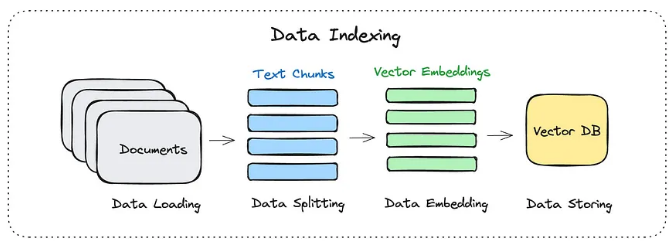

Split the document text into chunks.
Chunking strategy: chunk size and overlap plays key role:
  - Too small: fragments lose context
  - Too large: wasted tokens, irrelevant passages
  - Smart chunking (semantic splits, overlap, hierarchical chunking) improves recall

Embedding model choice: different models capture semantics differently

Create an indexing method (vector DB) for the embeddings: FAISS, ChromaDB etc
  - vector DB uses hash indexes for exact matches
  - uses approximate nearest neighbour search
  - FAISS → mostly an indexing library (you handle storage yourself)
  - ChromaDB, Pinecone, Weaviate, Milvus → full-fledged vector databases (indexing + storage + metadata + APIs)
  - Knowledge Base = Vector Database + Documents

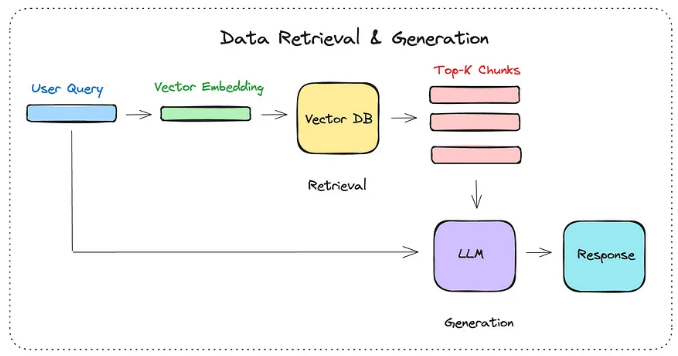

Steps in RAG
  - User Query is converted into a vector by the same embedding model used for documents
  - Similarity Search in Vector DB: query embedding is compared against all indexed embeddings in the vector DB. Approximate Nearest Neighbor search returns the Top-K most relevant
  - Context Assembly (Retrieval): retrieved chunks form the context window that will be fed into the LLM
  - The LLM gets both your query + retrieved context
  - Since the model now has relevant info, it can generate a grounded, factual answer instead of hallucinating

Prompt Engineering
  - As LLMs are causal decoders, they generate tokens sequentially and attend more strongly to recent tokens
  - The order of sections inside a prompt matters: [Instruction → Context → Question → Output]

 - Instruction Placement : placing at the very beginning establishes the role and rules for the LLM
 - Context Placement : If context is placed before the question, the model "absorbs" the knowledge first, then applies it to the query. If context comes after the question, the LLM might start answering before it even reads the evidence
 - Question Placement : query just before generation makes sure it is fresh in the model’s attention. If the query is buried before context, the model may drift and overfit to context instead of the user’s need
 - Output Formatting : Putting output instructions (e.g., “Answer in JSON format” or “Cite sources”) at the very end makes them the last thing in memory, which improves compliance


 - Recency bias: Decoder-only LLMs (like GPT/Llama) weigh recent tokens more heavily
 - Instruction-first: Sets global constraints early → “never hallucinate”
 - Context-before-question: Ensures knowledge is top-of-mind when answering
 - Output-last: Reminds model how to respond just before generation.

rag_prompt_template = """
You are a helpful assistant. 
Follow the rules strictly:
1. Answer ONLY from the provided context.
2. If the answer is not in the context, reply: "I don't know."
3. Always provide citations by referring to the source IDs.
4. Respond in a structured JSON format.

### Context:
{context}

### Question:
{question}

### Output (in JSON):
{{
  "answer": "<your grounded answer here>",
  "sources": ["<list of relevant source IDs>"]
}}
"""


from langchain.prompts import PromptTemplate
from langchain.chains import RetrievalQA

# Define template
prompt = PromptTemplate(
    input_variables=["context", "question"],
    template=rag_prompt_template,
)

# Create RAG chain with custom prompt
qa = RetrievalQA.from_chain_type(
    llm=llm,
    retriever=db.as_retriever(),
    chain_type="stuff",
    chain_type_kwargs={"prompt": prompt}
)

# Query
response = qa.run("What are the side effects of ibuprofen?")
print(response)


In [8]:
import torch
from transformers import AutoTokenizer, AutoModelForCausalLM, pipeline, BitsAndBytesConfig
import gradio as gr
from langchain.llms import HuggingFacePipeline
from langchain import PromptTemplate, LLMChain
from langchain.document_loaders import PyPDFLoader
from langchain.text_splitter import RecursiveCharacterTextSplitter
from langchain.embeddings import HuggingFaceEmbeddings
from langchain.vectorstores import FAISS
from langchain.chains import RetrievalQA

In [2]:
bnb_config = BitsAndBytesConfig(load_in_4bit=True,
                                bnb_4bit_use_double_quant=True,
                                bnb_4bit_quant_type='nf4',
                                bnb_4bit_compute_dtype=torch.bfloat16)

In [3]:
model_name = "C:\\Abhishek_Data\\Models\\Transformer_compatible\\Llama-3.2-3B-Instruct"

model = AutoModelForCausalLM.from_pretrained(
    model_name,
    quantization_config=bnb_config,
    device_map='auto')

Loading checkpoint shards: 100%|██████████| 2/2 [00:03<00:00,  1.92s/it]


In [4]:
tokenizer = AutoTokenizer.from_pretrained(model_name)
tokenizer.pad_token = tokenizer.eos_token

In [5]:
pipeline = pipeline(task='text-generation', model=model, tokenizer=tokenizer, max_new_tokens=128)

Device set to use cuda:0


Chatbot application : replace with proper prompt template from Prompt Engineering section, load 10 pdfs from last section and use guard rails

In [ ]:
# Load the PDF document
loader = PyPDFLoader("C:\\Users\\Abhishek\\Downloads\\harrypotter.pdf") # Replace with your PDF file path
documents = loader.load()

# Split the text into chunks
text_splitter = RecursiveCharacterTextSplitter(chunk_size=500, chunk_overlap=50)
texts = text_splitter.split_documents(documents)

# Create embeddings
embeddings = HuggingFaceEmbeddings()

# Create a vector store from the documents using embeddings
db = FAISS.from_documents(texts, embeddings)

llm = HuggingFacePipeline(pipeline=pipeline)

# Create a retrieval QA chain
qa = RetrievalQA.from_chain_type(llm=llm, chain_type="stuff", retriever=db.as_retriever())

def chatbot(input_text):
  response = qa.run(input_text)
  return response

iface = gr.Interface(
    fn=chatbot,
    inputs=gr.Textbox(lines=2, placeholder="Enter your question here..."),
    outputs="text",
    title="Llama 3.2 Chatbot with PDF",
    description="Ask me anything about the PDF!"
)

iface.launch()


Retreival Guardrail
  - Drop irrelevant/short chunks
  - Option to add metadata filtering (filter={"access": "public"} if the docs had metadata)
  
Output Guardrails
  - Enforce groundedness (adds source note if key terms are missing citations)
  - Truncate overly long answers
  - Sanitize outputs with regex

In [ ]:
from langchain.chains import RetrievalQA
from langchain.prompts import PromptTemplate
import re

# ------------------------------
# 1. Retrieval Guardrails
# ------------------------------
# Example: metadata filtering (only include "public" docs, if metadata exists)
retriever = db.as_retriever(search_kwargs={"k": 3})  # retrieve top 3 docs

# Wrap retriever to filter irrelevant results
def safe_retriever(query):
    docs = retriever.get_relevant_documents(query)

    # Guardrail 1: Drop very low-relevance matches (using simple heuristic)
    safe_docs = [d for d in docs if len(d.page_content.strip()) > 30]

    if not safe_docs:
        return [{"page_content": "No relevant context found."}]
    return safe_docs

# ------------------------------
# 2. Output Guardrails
# ------------------------------
def output_guardrails(answer: str) -> str:
    """
    Enforces guardrails on LLM output:
      - Strip unsafe content
      - Ensure groundedness
      - Limit answer length
    """

    # Guardrail 1: Block toxic / unsafe words (basic example)
    forbidden = ["kill", "suicide", "hack", "password"]
    if any(word in answer.lower() for word in forbidden):
        return "Response blocked due to unsafe content"

    # Guardrail 2: Ensure citations / groundedness (requires docs in context)
    if "ibuprofen" in answer.lower() and "source" not in answer.lower():
        answer += "\n\n(Source: Retrieved from PDF)"

    # Guardrail 3: Limit answer length
    if len(answer) > 600:
        answer = answer[:600] + "...\n Answer truncated for safety."

    # Guardrail 4: Simple regex sanitization
    answer = re.sub(r"[^A-Za-z0-9\s,.!?;:'\"-]", "", answer)

    return answer


# ------------------------------
# 3. RetrievalQA with Guardrails
# ------------------------------
qa = RetrievalQA.from_chain_type(
    llm=llm,
    chain_type="stuff",
    retriever=retriever  # base retriever
)

def chatbot(input_text):
    # Step 1: Use safe retriever
    context_docs = safe_retriever(input_text)

    # Step 2: Run QA on filtered docs
    response = qa.combine_documents_chain.run(
        {"question": input_text, "input_documents": context_docs}
    )

    # Step 3: Apply output guardrails
    safe_response = output_guardrails(response)
    return safe_response


# ------------------------------
# 4. Gradio UI
# ------------------------------
iface = gr.Interface(
    fn=chatbot,
    inputs=gr.Textbox(lines=2, placeholder="Enter your question here..."),
    outputs="text",
    title="📖 Llama 3.2 PDF Chatbot (with Guardrails)",
    description="Ask questions about the PDF! Guardrails added for safe retrieval & output."
)

iface.launch()


RAG pipeline using 10 PDFs

In [1]:
import gradio as gr
from langchain_community.document_loaders import PyPDFLoader
from langchain.text_splitter import RecursiveCharacterTextSplitter
from langchain_community.llms import HuggingFacePipeline
from langchain_community.vectorstores import Chroma, FAISS
from langchain.embeddings import HuggingFaceEmbeddings
from langchain.chains import RetrievalQA
from langchain.prompts import PromptTemplate
import torch
import os
import gc

# Detect available GPUs
num_gpus = torch.cuda.device_count()
if num_gpus == 0:
    raise RuntimeError("No GPUs detected. This application requires at least one NVIDIA GPU.")

# Initialize embedding model (CPU for embeddings to save GPU memory)
embeddings = HuggingFaceEmbeddings() #model_name="all-MiniLM-L6-v2")

# Initialize LLM pipeline for GPU (no device_map to avoid accelerate conflict)
llm = HuggingFacePipeline.from_model_id(
    model_id="C:\\Abhishek_Data\\Models\\Transformer_compatible\\Llama-3.2-3B-Instruct",
    task="text-generation",
    pipeline_kwargs={"max_new_tokens": 200, "do_sample": True, "temperature": 0.7},
    model_kwargs={"torch_dtype": torch.float16}  # Use FP16 for 8GB GPU(s)
)

def process_pdfs(pdf_files, vector_store_type):
    try:
        if not pdf_files:
            return "Please upload at least one PDF.", None, None
        if len(pdf_files) > 10:
            return "Error: Maximum 10 PDFs allowed.", None, None
        
        # Load and split all PDFs
        all_chunks = []
        for pdf_file in pdf_files:
            # Use the temporary file path from Gradio's NamedString
            if not hasattr(pdf_file, 'name') or not pdf_file.name.endswith('.pdf'):
                return f"Error: Invalid file format for {pdf_file.name if hasattr(pdf_file, 'name') else 'unknown file'}. Please upload PDF files.", None, None
            
            # Load and split PDF using the temporary file path
            loader = PyPDFLoader(pdf_file.name)
            documents = loader.load()
            text_splitter = RecursiveCharacterTextSplitter(chunk_size=500, chunk_overlap=50)
            chunks = text_splitter.split_documents(documents)
            all_chunks.extend(chunks)
        
        # Create vector store based on user selection
        if vector_store_type == "ChromaDB":
            vectorstore = Chroma.from_documents(all_chunks, embeddings, collection_name="pdf_chunks")
        else:  # FAISS
            # Configure FAISS for multi-GPU if available
            faiss_resources = [{"gpu_id": i} for i in range(num_gpus)] if num_gpus > 1 else None
            vectorstore = FAISS.from_documents(all_chunks, embeddings)
            if faiss_resources:
                vectorstore.index_to_gpu(faiss_resources)  # Move FAISS index to GPUs
        
        # Define prompt template
        prompt_template = """<|start_header_id|>system<|end_header_id>
You are a helpful assistant. Answer the question based on the provided context from multiple documents.
<|eot_id><|start_header_id|>user<|end_header_id>
Context: {context}

Question: {question}
<|eot_id><|start_header_id|>assistant<|end_header_id>"""
        prompt = PromptTemplate(template=prompt_template, input_variables=["context", "question"])
        
        # Create RAG chain
        qa_chain = RetrievalQA.from_chain_type(
            llm=llm,
            chain_type="stuff",
            retriever=vectorstore.as_retriever(search_kwargs={"k": 3}),
            chain_type_kwargs={"prompt": prompt}
        )
        
        # Clean up GPU memory across all GPUs
        for i in range(num_gpus):
            torch.cuda.set_device(i)
            torch.cuda.empty_cache()
        gc.collect()
        
        return f"Processed {len(pdf_files)} PDF(s) successfully. Total chunks: {len(all_chunks)}. Using {num_gpus} GPU(s). You can now ask questions.", vectorstore, qa_chain
    except Exception as e:
        return f"Error processing PDFs: {str(e)}", None, None

def answer_question(query, vectorstore, qa_chain):
    if vectorstore is None or qa_chain is None:
        return "Please upload and process at least one PDF first."
    try:
        result = qa_chain({"query": query})
        # Clear GPU memory after query
        for i in range(num_gpus):
            torch.cuda.set_device(i)
            torch.cuda.empty_cache()
        gc.collect()
        return result["result"].strip()
    except Exception as e:
        return f"Error generating answer: {str(e)}"

def cleanup():
    # Clean up GPU memory and vector store
    try:
        for i in range(num_gpus):
            torch.cuda.set_device(i)
            torch.cuda.empty_cache()
        gc.collect()
        Chroma(collection_name="pdf_chunks", embedding_function=embeddings).delete_collection()
    except:
        pass
    return "Cleanup completed."

with gr.Blocks() as demo:
    gr.Markdown("# RAG App with LangChain, Llama 3.2-3B-Instruct, and Chroma/FAISS (Multi-GPU Optimized, Multi-PDF)")
    
    pdf_input = gr.File(label="Upload up to 10 PDFs", file_types=[".pdf"], file_count="multiple")
    vector_store_choice = gr.Dropdown(choices=["ChromaDB", "FAISS"], label="Vector Store", value="ChromaDB")
    process_btn = gr.Button("Process PDFs")
    status = gr.Textbox(label="Status")
    
    query_input = gr.Textbox(label="Ask a question")
    answer_btn = gr.Button("Get Answer")
    output = gr.Textbox(label="Answer")
    
    # Hidden states for vectorstore and QA chain
    vectorstore_state = gr.State()
    qa_chain_state = gr.State()
    
    process_btn.click(
        process_pdfs,
        inputs=[pdf_input, vector_store_choice],
        outputs=[status, vectorstore_state, qa_chain_state]
    )
    
    answer_btn.click(
        answer_question,
        inputs=[query_input, vectorstore_state, qa_chain_state],
        outputs=[output]
    )
    
    # Cleanup on app close
    demo.unload(cleanup)

demo.launch()

c:\Users\Abhishek\anaconda3\envs\pytorch-gpu\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
C:\Users\Abhishek\AppData\Local\Temp\ipykernel_23756\3426618078.py:19: LangChainDeprecationWarning: The class `HuggingFaceEmbeddings` was deprecated in LangChain 0.2.2 and will be removed in 1.0. An updated version of the class exists in the :class:`~langchain-huggingface package and should be used instead. To use it run `pip install -U :class:`~langchain-huggingface` and import as `from :class:`~langchain_huggingface import HuggingFaceEmbeddings``.
  embeddings = HuggingFaceEmbeddings() #model_name="all-MiniLM-L6-v2")
C:\Users\Abhishek\AppData\Local\Temp\ipykernel_23756\3426618078.py:19: LangChainDeprecationWarning: Default values for HuggingFaceEmbeddings.model_name were deprecated in LangChain 0.2.16 and will be removed

* Running on local URL:  http://127.0.0.1:7860
* To create a public link, set `share=True` in `launch()`.


C:\Users\Abhishek\AppData\Local\Temp\ipykernel_23756\3426618078.py:92: LangChainDeprecationWarning: The method `Chain.__call__` was deprecated in langchain 0.1.0 and will be removed in 1.0. Use :meth:`~invoke` instead.
  result = qa_chain({"query": query})
C:\Users\Abhishek\AppData\Local\Temp\ipykernel_23756\3426618078.py:109: LangChainDeprecationWarning: The class `Chroma` was deprecated in LangChain 0.2.9 and will be removed in 1.0. An updated version of the class exists in the :class:`~langchain-chroma package and should be used instead. To use it run `pip install -U :class:`~langchain-chroma` and import as `from :class:`~langchain_chroma import Chroma``.
  Chroma(collection_name="pdf_chunks", embedding_function=embeddings).delete_collection()
c:\Users\Abhishek\anaconda3\envs\pytorch-gpu\Lib\site-packages\gradio\blocks.py:1950: UserWarning: A function (cleanup) returned too many output values (needed: 0, returned: 1). Ignoring extra values.
    Output components:
        []
    Outp